In [76]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer ,Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision ,Recall , Accuracy , F1Score
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from sklearn.metrics import roc_curve , confusion_matrix ,auc
import seaborn as sns

In [40]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

In [41]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [42]:
dataset = dataset[0]

In [43]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size))
  return train_dataset, test_dataset ,val_dataset

In [44]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [45]:
DATASET_SIZE

27558

In [46]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [47]:
len(test_dataset)

2755

In [48]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [49]:
train_dataset.take(1).as_numpy_iterator()

In [50]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [51]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

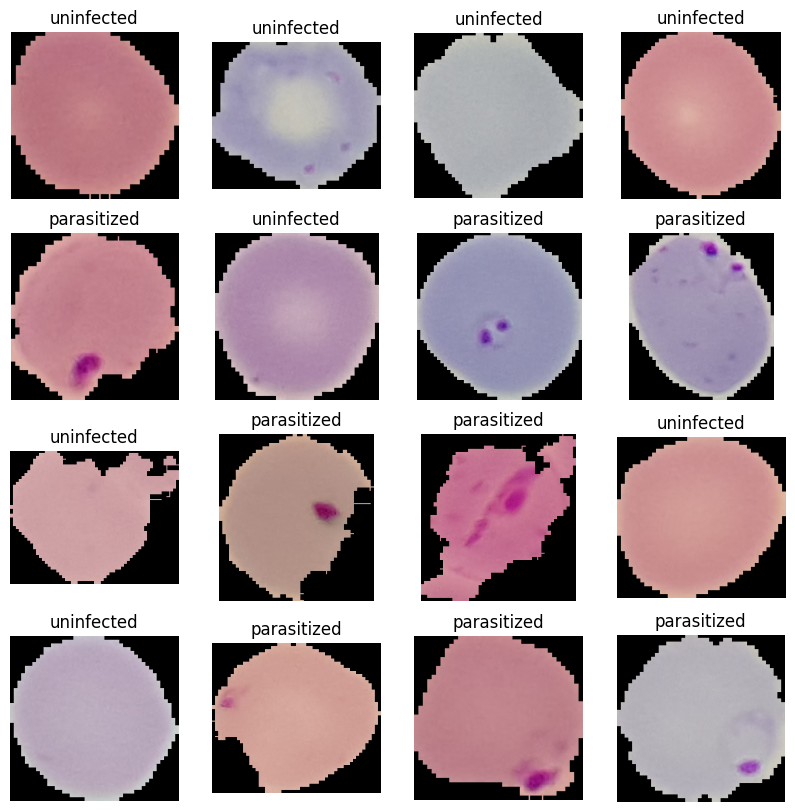

In [52]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [53]:
IMAGE_SIZE = 224

In [54]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [55]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [56]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(133, 133, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [57]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [58]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [59]:
test_dataset = test_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(1).prefetch(tf.data.AUTOTUNE)

In [60]:
input_tensor = Input(shape = (IMAGE_SIZE , IMAGE_SIZE , 3))

x = Conv2D(filters = 6 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)

x = Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2) , strides=2)(x)

x = Flatten()(x)

x = Dense(100 , activation = 'relu')(x)
x = BatchNormalization()(x)

x = Dense(10 , activation = 'relu')(x)
x = BatchNormalization()(x)

output = Dense(1 , activation = 'sigmoid')(x)


model = Model(inputs = input_tensor , outputs= output )



In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 219, 219, 6)       654       
                                                                 
 batch_normalization_4 (Bat  (None, 219, 219, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 109, 109, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 107, 107, 16)      64  

In [62]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def F1Score(y_true, y_pred, precision=precision, recall=recall):
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return (2 * precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon())

In [63]:
metrics = [
    TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc'),F1Score
]



In [64]:
model.compile(
    optimizer = Adam(learning_rate= 0.01),
    loss = BinaryCrossentropy(),
              metrics = metrics,
              )

In [65]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=5 , verbose = 1)

Epoch 1/5
689/689 [==============================] - 49s 65ms/step - loss: 0.3319 - tp: 9716.0000 - fp: 1772.0000 - tn: 9248.0000 - fn: 1310.0000 - accuracy: 0.8602 - precision: 0.8458 - recall: 0.8812 - auc: 0.9315 - F1Score: 0.7883 - val_loss: 1.0260 - val_tp: 20.0000 - val_fp: 1.0000 - val_tn: 1397.0000 - val_fn: 1339.0000 - val_accuracy: 0.5140 - val_precision: 0.9524 - val_recall: 0.0147 - val_auc: 0.9402 - val_F1Score: 0.8378
Epoch 2/5
689/689 [==============================] - 50s 72ms/step - loss: 0.2146 - tp: 10406.0000 - fp: 1023.0000 - tn: 10000.0000 - fn: 617.0000 - accuracy: 0.9256 - precision: 0.9105 - recall: 0.9440 - auc: 0.9661 - F1Score: 0.8472 - val_loss: 0.2038 - val_tp: 1292.0000 - val_fp: 114.0000 - val_tn: 1283.0000 - val_fn: 68.0000 - val_accuracy: 0.9340 - val_precision: 0.9189 - val_recall: 0.9500 - val_auc: 0.9738 - val_F1Score: 0.8712
Epoch 3/5
689/689 [==============================] - 43s 63ms/step - loss: 0.1969 - tp: 10419.0000 - fp: 891.0000 - tn: 10132

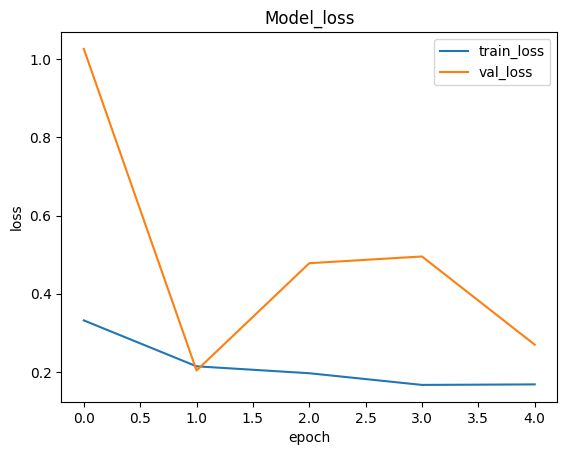

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

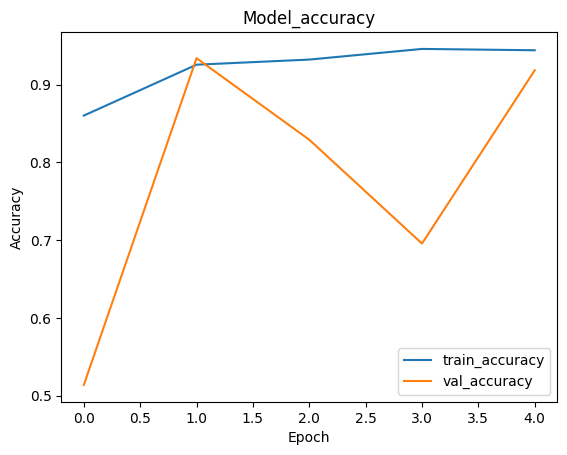

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [68]:
model.evaluate(test_dataset)

2755/2755 [==============================] - 24s 5ms/step - loss: 0.2434 - tp: 1250.0000 - fp: 51.0000 - tn: 1319.0000 - fn: 135.0000 - accuracy: 0.9325 - precision: 0.9608 - recall: 0.9025 - auc: 0.9788 - F1Score: 0.9056


[0.2434491068124771,
 1250.0,
 51.0,
 1319.0,
 135.0,
 0.9324864149093628,
 0.9607993960380554,
 0.9025270938873291,
 0.9787654280662537,
 0.9056095480918884]

In [69]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('parasitized')
  else:
    return str('Uninfected')

1/1 [==============================] - 0s 28ms/step


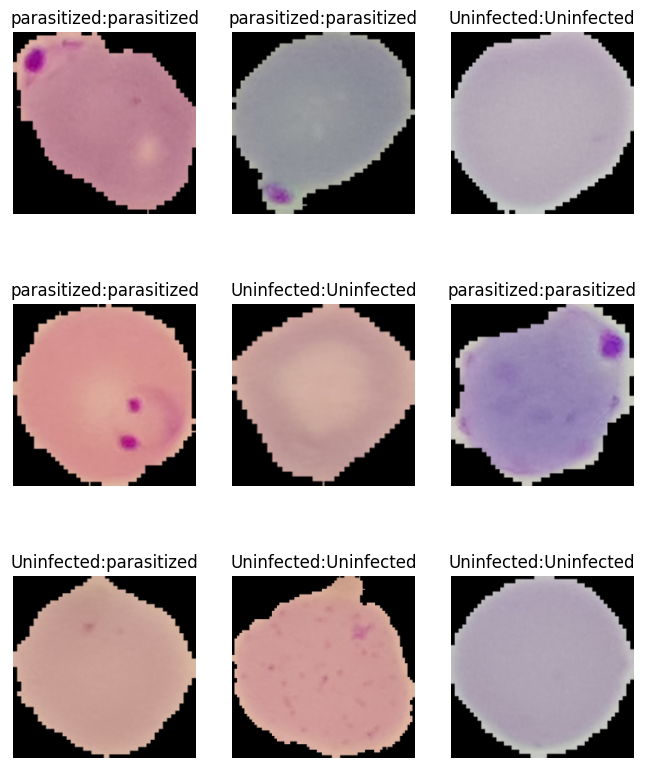

In [70]:
plt.figure(figsize=(8,10))
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [71]:
labels = []
images = []

for i, (image, label) in enumerate(test_dataset):
      labels.append(label.numpy()[0])
      images.append(model.predict(image)[0][0])

1/1 [==============================] - 0s 36ms/step


In [72]:
y_test = np.array(labels)
y_pred_proba = np.array(images)

In [73]:
def prediction (pred):
  if pred >=0.5 :
    return 1
  else:
    return 0

In [74]:
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

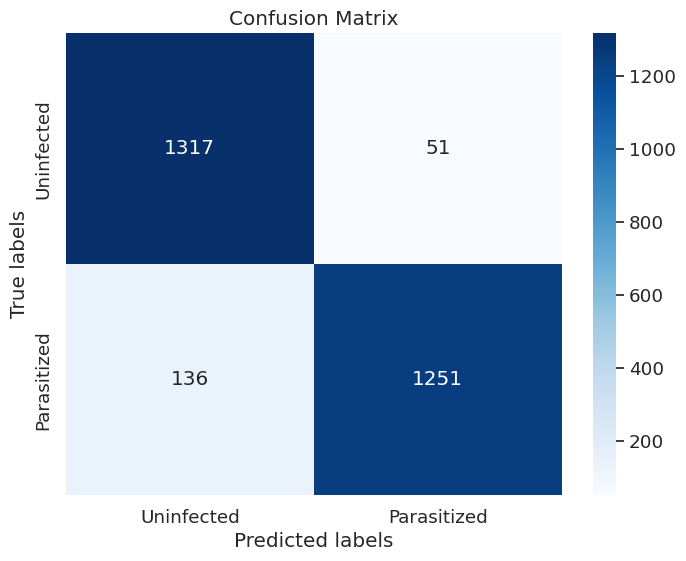

In [77]:
cm = confusion_matrix(y_test ,y_pred )
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Uninfected','Parasitized'], yticklabels=['Uninfected','Parasitized'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

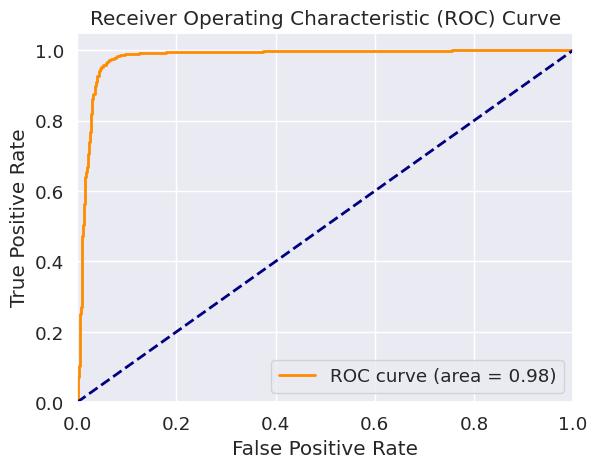

In [79]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [80]:
from sklearn.metrics import precision_score, recall_score ,f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [81]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1 score = {f1}")

precision = 0.9608294930875576
recall = 0.9019466474405191
f1 score = 0.9304574191149126
